<a href="https://colab.research.google.com/github/JollygreenG-10/Cybersecurity/blob/main/Federated_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet tensorflow-federated
!pip install --quiet --upgrade dp-accounting
!pip install tensorflow_privacy
import numpy as np
import random
import cv2
import pandas as pd
import os
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
import collections
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import tensorflow_federated as tff
import tensorflow_privacy

from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy


In [2]:
#Retrieve data for friday afternoon ddos
data_full = pd.read_csv('Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
data_full = pd.DataFrame(data_full)

#strip whitespace from titles
data_full.columns = data_full.columns.str.replace(" ", "")

In [ ]:
#explore data
data_full.info()
data_full['Label'].value_counts()
data_full.describe()

In [4]:
#Encode response variable and shuffle data
mapping_dict = {'BENIGN':0, 'DDoS':1}
data_full['Label'] = data_full['Label'].map(mapping_dict)
data_full = data_full.sample(frac = 1)
labels = data_full['Label']
data_full.drop(['Label', 'FlowBytes/s', 'FlowPackets/s'], axis = 1, inplace = True)

#scale features
for col in data_full.columns:
  scaler = MinMaxScaler()
  try:
    data_full[col] = scaler.fit_transform(data_full[[col]])
  except:
    print(col)


#split data into train and test
x_train, x_test, y_train, y_test = train_test_split(data_full, labels, test_size = 0.2, random_state = 10)


In [5]:
def build(shape):
    model = Sequential()
    model.add(Dense(shape, input_shape=(shape,)))
    model.add(Activation("relu"))
    model.add(Dense(200))
    model.add(Activation("relu"))
    model.add(Dense(200))
    model.add(Activation("relu"))
    model.add(Dense(1, activation = 'sigmoid'))
    return model

lr = 0.0001
comms_round = 5
loss=tf.keras.losses.BinaryCrossentropy(reduction=tf.losses.Reduction.NONE)
metrics = ['accuracy', 'Precision', 'Recall']

# moved this to earlier lines to use for 1st model
def test_model(x_test, y_test,  model):
    pred = model.predict(x_test).round(1).astype(int)
    acc = accuracy_score(y_test, pred)
    prec = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    print(f'Global Model Accuracy is {acc}, precision is {prec}, recall is {recall}, f1 is {f1}')
    return {'Accuracy': acc, 'Precision': prec, 'Recall': recall, 'f1': f1}

In [ ]:
#build baseline model
x_train = np.array(x_train).astype('float')
y_train = np.array(y_train)
SGD_model = build(x_train.shape[1])

SGD_model.compile(loss=loss,
              optimizer=Adam(),
              metrics=metrics)

# fit the SGD training data to model
fitted_model = SGD_model.fit(x_train, y_train, epochs=50, batch_size=96)

In [7]:
#test model
result1 = test_model(x_test,y_test,SGD_model)

1411/1411 [==============================] - 2s 1ms/step
Global Model Accuracy is 0.999623468958338, precision is 0.9999610743479953, recall is 0.9993775530052519, f1 is 0.9996692285241755


# Federated Learning Model 1


##Create nodes for separation of data

In [10]:
def create_nodes(data, labels, num_nodes: int):
  init = 'Node'
  node_names = [init+str(i+1) for i in range(num_nodes)]
  data = np.array(data)

  data = list(zip(data, labels))
  random.shuffle(data)

  shard_size = len(data)//num_nodes

  shards = [data[i:i+shard_size] for i in range(0, shard_size*num_nodes, shard_size)]
  assert(len(shards) == num_nodes)

  return {node_names[i] : shards[i] for i in range(len(node_names))}

nodes = create_nodes(x_train, y_train, 50)

def batch_data(shard):
  data, label = zip(*shard)
  dataset = tf.data.Dataset.from_tensor_slices((np.array(data), np.array(label)))
  return dataset.shuffle(len(label)).batch(92)



In [11]:
#process and batch the training data for each client
nodes_batched = dict()
for (node_name, data) in nodes.items():

  nodes_batched[node_name] = batch_data(data)

#process and batch the test set
test_batched = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(len(y_test))

In [12]:
from numpy.random import normal
def weight_scaling_factor(node_train, node_name):
    node_names = list(node_train.keys())
    #get the bs
    bs = list(node_train[node_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(node_train[node_name]).numpy() for node_name in node_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(node_train[node_name]).numpy()*bs
    return local_count/global_count



def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final


def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    average_weights = list()
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        average_weights.append(layer_mean)
    return average_weights



In [ ]:
#initialize global model
global_model = build(76)

#commence global training loop
for comm_round in range(comms_round):

    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()

    #initial list to collect local model weights after scaling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    node_names= list(nodes_batched.keys())
    random.shuffle(node_names)

    #loop through each client and create new local model
    for node in node_names:
        local_model = build(76)
        local_model.compile(loss=loss,
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=metrics)

        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)

        #fit local model with client's data
        local_model.fit(nodes_batched[node], epochs=4)

        #scale the model weights and add to list
        scaling_factor = weight_scaling_factor(nodes_batched, node)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)

        #clear session to free memory after each communication round
        K.clear_session()

    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)

    #update global model
    global_model.set_weights(average_weights)

In [21]:
results2 = test_model(x_test, y_test, global_model)

1411/1411 [==============================] - 2s 1ms/step
Global Model Accuracy is 0.9887483665197457, precision is 0.9995638209286649, recall is 0.9806652402256371, f1 is 0.9900243500117822


#Federated Learning with Differential Privacy

In [40]:
optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=1.4,
    noise_multiplier=3,
    num_microbatches=23,
    learning_rate=0.25)


In [ ]:
#initialize global model
global_model = build(76)

#commence global training loop
for comm_round in range(comms_round):

    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()

    #initial list to collect local model weights after scaling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    node_names= list(nodes_batched.keys())
    random.shuffle(node_names)

    #loop through each client and create new local model
    for node in node_names:
        local_model = build(76)
        local_model.compile(loss=loss,
                      optimizer=optimizer,
                      metrics=metrics)

        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)

        #fit local model with client's data
        local_model.fit(nodes_batched[node], epochs=4)
        priv = compute_dp_sgd_privacy.compute_dp_sgd_privacy_statement(number_of_examples=3612,
                                              batch_size=40,
                                              noise_multiplier=3,
                                              num_epochs=4,
                                              delta=1e-5)
        print(priv)

        #scale the model weights and add to list
        scaling_factor = weight_scaling_factor(nodes_batched, node)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)

        #clear session to free memory after each communication round
        K.clear_session()

    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)

    #update global model
    global_model.set_weights(average_weights)

In [33]:
results3 = test_model(x_test,y_test,global_model)


1411/1411 [==============================] - 3s 2ms/step
Global Model Accuracy is 0.9775631796939024, precision is 0.962189278227014, recall is 0.9998832911884847, f1 is 0.98067420874907


In [36]:
### visualizations
import matplotlib.pyplot as plt

In [34]:
def make_plot(results, measurement):
  # creating the dataset
  data = {}
  for model, result in results.items():
    data[model] = result[measurement]

  x = list(data.keys())
  y = list(data.values())

  fig = plt.figure(figsize = (10, 5))

  # creating the bar plot
  plt.bar(x, y, color ='maroon',
          width = 0.4)

  #plt.xlabel("Model")
  plt.ylabel(measurement)
  plt.title(measurement + " comparsion across models")
  plt.show()

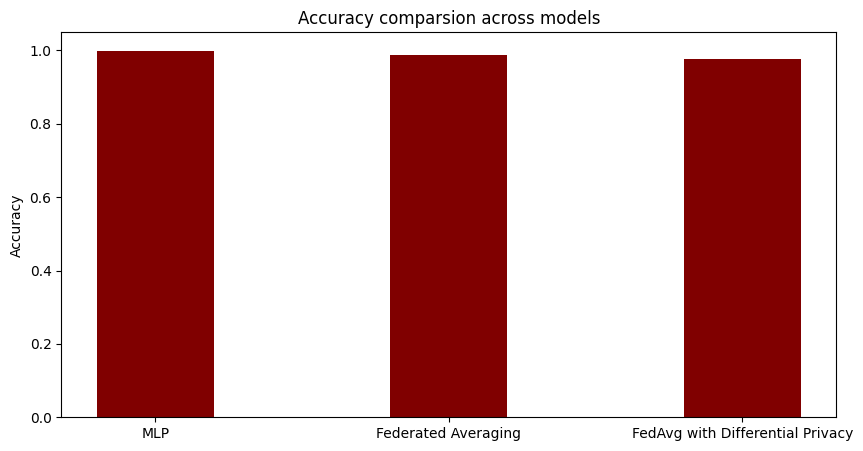

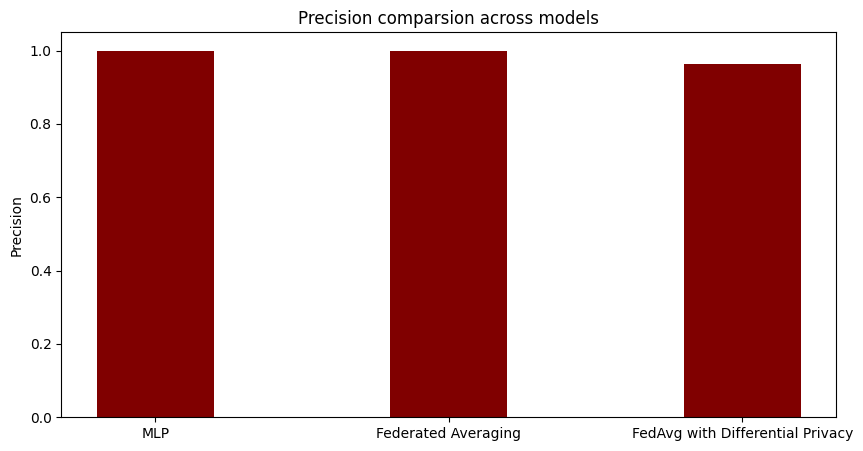

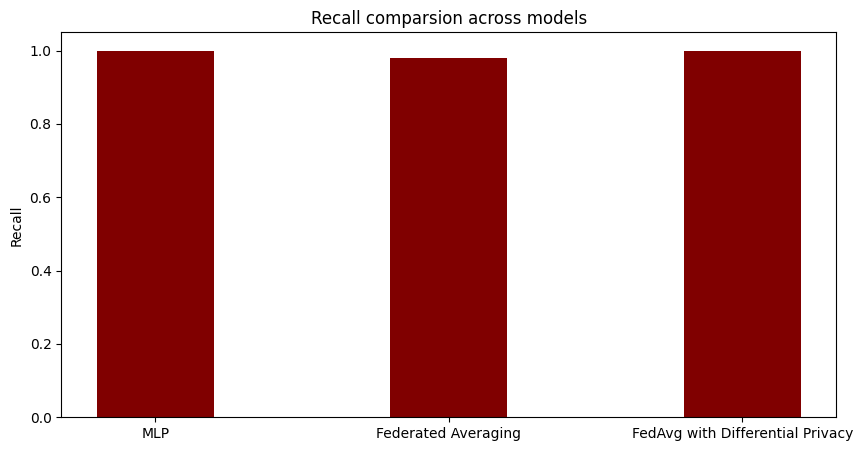

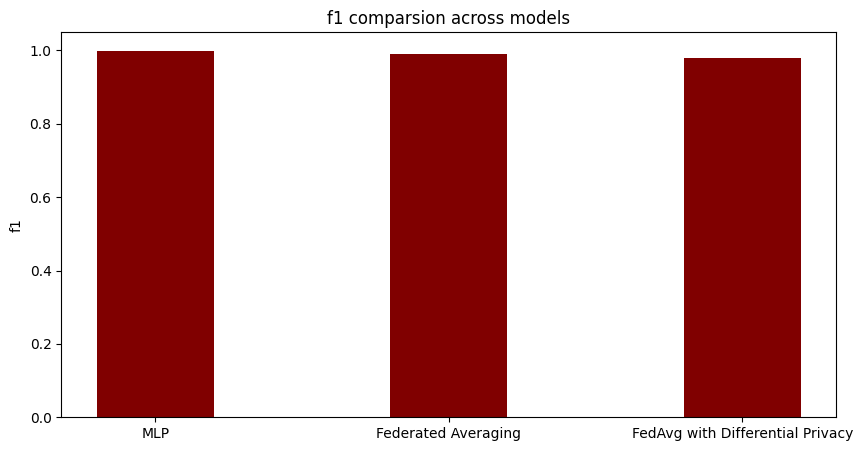

In [37]:
all_results = {'MLP': result1,
               'Federated Averaging': results2,
               'FedAvg with Differential Privacy': results3}

make_plot(all_results, 'Accuracy')
make_plot(all_results, 'Precision')
make_plot(all_results, 'Recall')
make_plot(all_results, 'f1')

In [38]:
def make_plot2(results, measurements):
  # set width of bar
  barWidth = 0.25
  fig = plt.subplots(figsize =(12, 8))

  # set height of bar
  barHeight = []
  model_names = []
  for model, result in results.items():
    model_names.append(model)
    height = []
    for measure in measurements:
      height.append(result[measure])
    barHeight.append(height)

  model_count = len(barHeight)
  # Set position of bar on X axis
  bars = []
  for i in range(model_count):
    if i == 0:
      bars.append(np.arange(len(barHeight[0])))
    else:
      bars.append([x + barWidth for x in bars[i-1]])


  # Make the plot
  colours = ['r','g','b']
  for i in range(model_count):
    plt.bar(bars[i], barHeight[i], color = colours[i%len(colours)], width = barWidth,
            edgecolor ='grey', label =model_names[i])


  # Adding Xticks
  plt.xlabel('Measurements', fontweight ='bold', fontsize = 15)
  #plt.ylabel('Students passed', fontweight ='bold', fontsize = 15)
  plt.xticks([r + barWidth for r in range(len(barHeight[0]))],
          measurements)
  plt.title("All measurements comparsion across models")

  plt.legend()
  plt.show()

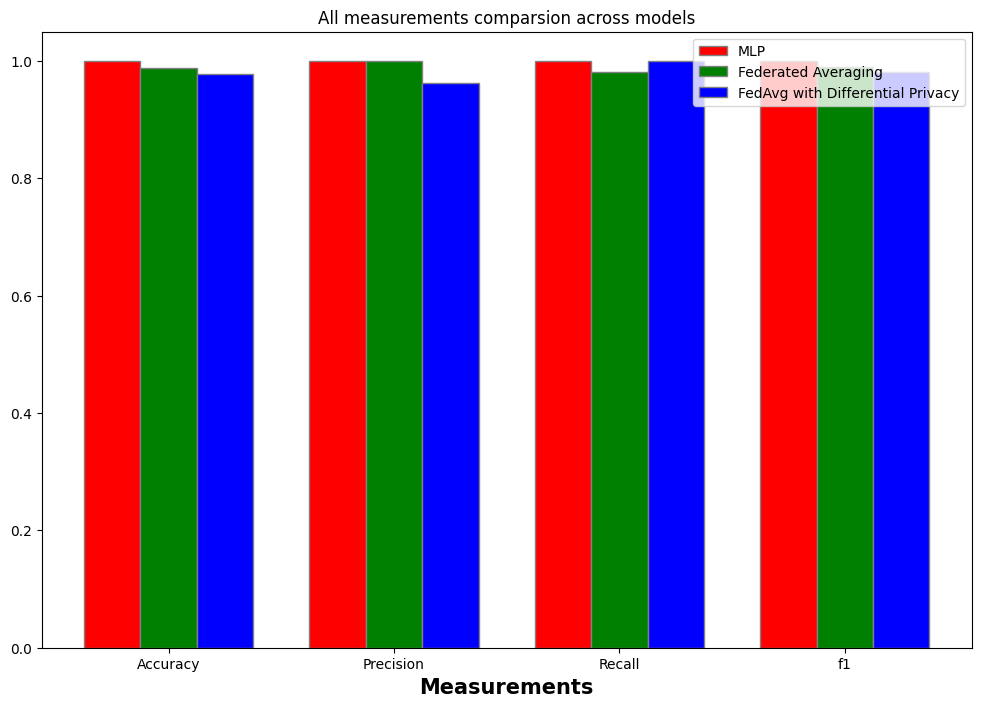

In [39]:
make_plot2(all_results, ['Accuracy', 'Precision', 'Recall', 'f1'])

In [ ]:
###### James notes for code:
# adjust:
# put test_model() earlier so the first model can also use it
# added return value to test_model() to retrieve results for plot

# new:
# make_plot() creates a bar plot comparsion on the models over one measurement
# make_plot2() creates a bar plot comparsion for all measurments
# color is arbitary, made both in case you have a preference


# comments:
# I think a few of the times when I ran it I had the 2nd or 3rd model with an accuracy and
#     all the other measurements at ~50%, not sure if its cuz i somehow ran it wrong or is it
#     cause the seed is not set and the results will differ every time i reran it
# Most recent run is printed above, they're not all ~99%, but they're decreasing at a resonable (i think?) rate
#     at the benefit of having better security
# After you add the noise term I can adjust the make_plots to accomodate

